# Number of Severe Tropical Cyclones in the Vicinity of Palau


```{glue:figure} tracks_fig
:scale: 50%
:align: center
```


```{glue:figure} time_cat_fig
:scale: 40%
:align: center
```

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [17]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os.path as op
import xarray as xr
import pandas as pd
from myst_nb import glue 
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../../functions")
from tcs import Extract_Circle
from data_downloaders import download_ibtracs

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_tcs import Plot_TCs_HistoricalTracks_Category
from ind_setup.plotting import plot_bar_probs, plot_tc_categories_trend
from ind_setup.tables import plot_df_table

from ind_setup.plotting import plot_bar_probs_ONI, add_oni_cat
from data_downloaders import  download_oni_index


In [2]:
lon_lat = [134.5, 5.5] #Palau location lon, lat
basin = 'WP'
r1 = 5 # Radius of the circular area in degrees

### IBTrACS
IBTrACS (International Best Track Archive for Climate Stewardship) is the most comprehensive global database of tropical cyclones. It compiles data from all major meteorological agencies worldwide, providing track, intensity, and metadata for storms from 1842 to present. It supports research on cyclone trends, risks, and climate variability.

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/netcdf/IBTrACS.ALL.v04r01.nc'
    tcs = download_ibtracs(url, basin = basin)
    tcs.to_netcdf(f"{path_data}/tcs_{basin}.nc")
else:
    tcs = xr.load_dataset(f"{path_data}/tcs_{basin}.nc")

## Analysis

In [5]:
tcs = tcs.isel(storm = np.where(tcs.isel(date_time = 0).time.dt.year >= 1950)[0])    

In [6]:
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',
    'wind': 'wmo_wind',
}
tcs_sel, tcs_sel_params = Extract_Circle(tcs, lon_lat[0], lon_lat[1], r1, d_vns, fillwinds=True)

In [7]:
tcm = tcs_sel.max(dim = 'date_time')
tcmin = tcs_sel.min(dim = 'date_time')

The static plot below shows all the severe TCs in the vicinity of Palau colored by its category. <br>
Severe TCs are defined here as those having a category equal or larger than 3

In [8]:
tcs_sel_params['category'] = (('storm'), np.where(np.isnan(tcs_sel_params.category), -1, tcs_sel_params.category))

In [9]:
tcs_sel_params_severe = tcs_sel_params.where(tcs_sel_params.category >=3, drop=True)
tcs_sel_severe = tcs_sel.sel(storm=tcs_sel_params_severe.storm)

## Plotting

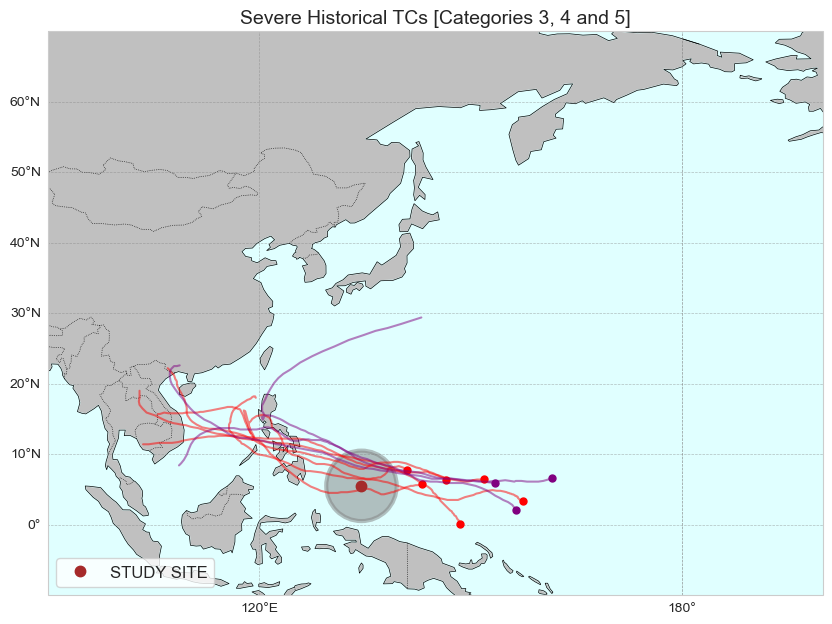

In [ ]:
lon1, lon2 = 90, 200
lat1, lat2 = -10, 70

# r1
fig, ax = Plot_TCs_HistoricalTracks_Category(
    tcs_sel_severe, tcs_sel_params_severe.category,
    lon1, lon2, lat1, lat2,
    lon_lat[0], lon_lat[1], r1,
)
ax.set_title('Severe Historical TCs [Categories 3, 4 and 5]', fontsize = 14)
glue("tracks_fig", fig, display=False)

plt.savefig(op.join(path_figs, 'F8_TCs_Historical_Severe.png'), dpi=300, bbox_inches='tight')


The plot below shows the trend of the number of severe TCs per year over time.

(<Figure size 1500x400 with 1 Axes>, <Axes: ylabel='Number of severe TCs'>)

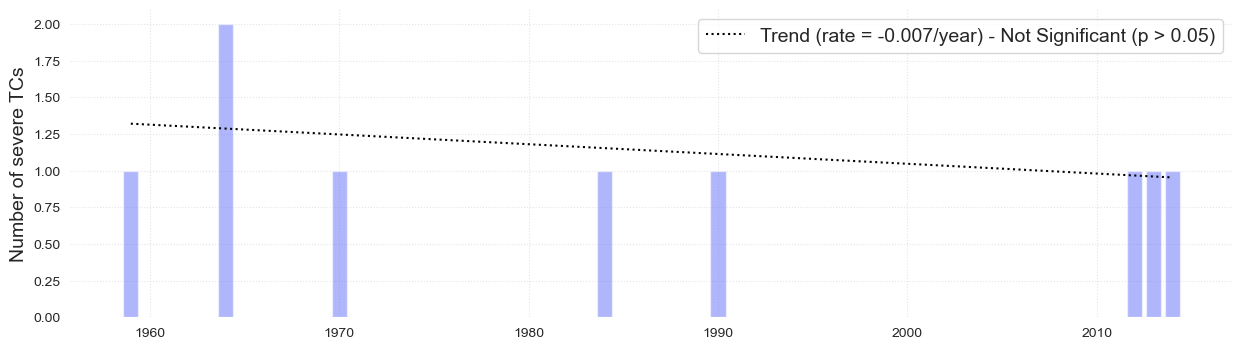

In [ ]:
tcs_sel_severe_params = tcs_sel_params.where(tcs_sel_params.category >=3, drop = True)
time = tcs_sel_severe_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)
plot_bar_probs(x = u, y = cu, figsize= (15, 4), trendline = True,
               y_label =  'Number of severe TCs')


The following bar plot displays the TC count per year and per category, as well as the trend. <br>
 The grey color represent those TCs in the record where no pressure or wind information is available to determine the corresponding category.

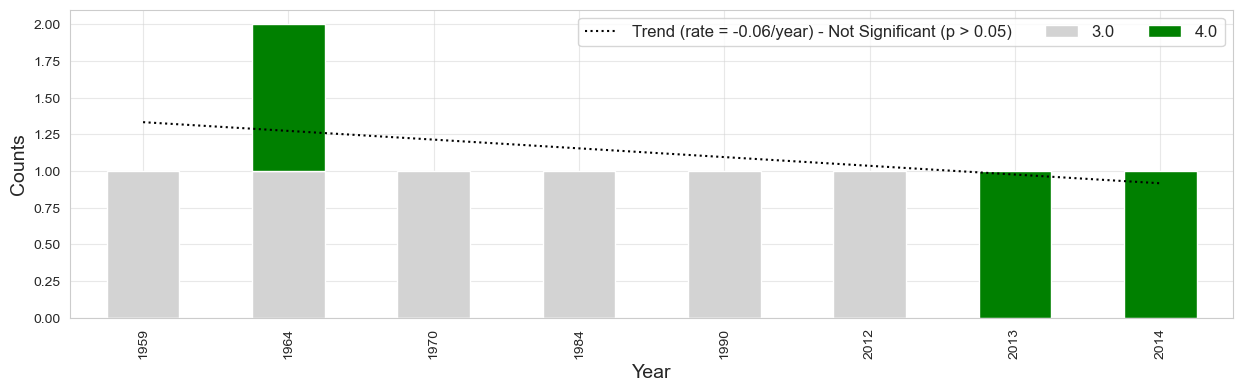

In [ ]:

tcs_sel_severe_params['month'] =  tcs_sel_severe_params.dmin_date.dt.month
fig = plot_tc_categories_trend(tcs_sel_severe_params, trendline = False)
plt.savefig(op.join(path_figs, 'F8_TCs_Historical_bars_category_severe.png'), dpi=300, bbox_inches='tight')
glue("time_cat_fig", fig, display=False)

To showcase the spatial distribution of the TC tracks for the different categories, a map is shown below representing all the TCs in the record for each category.

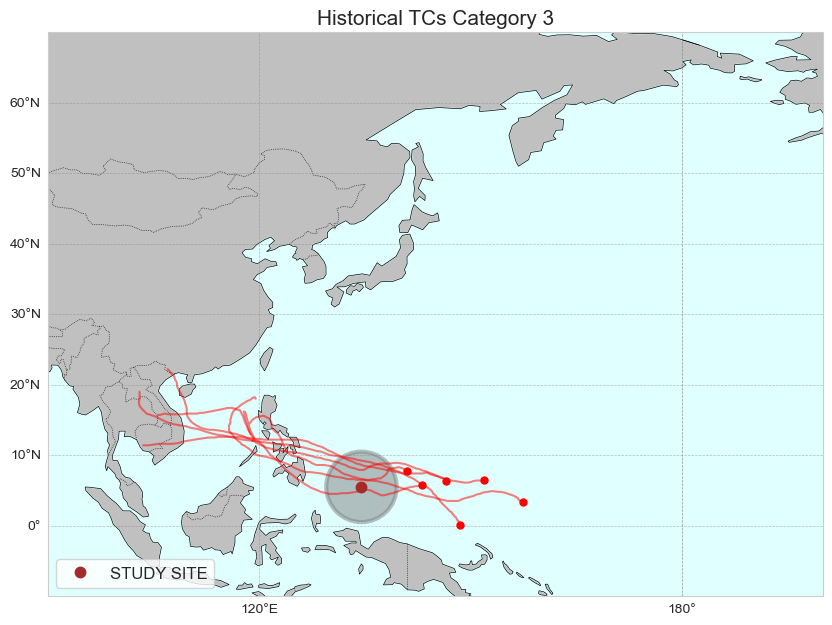

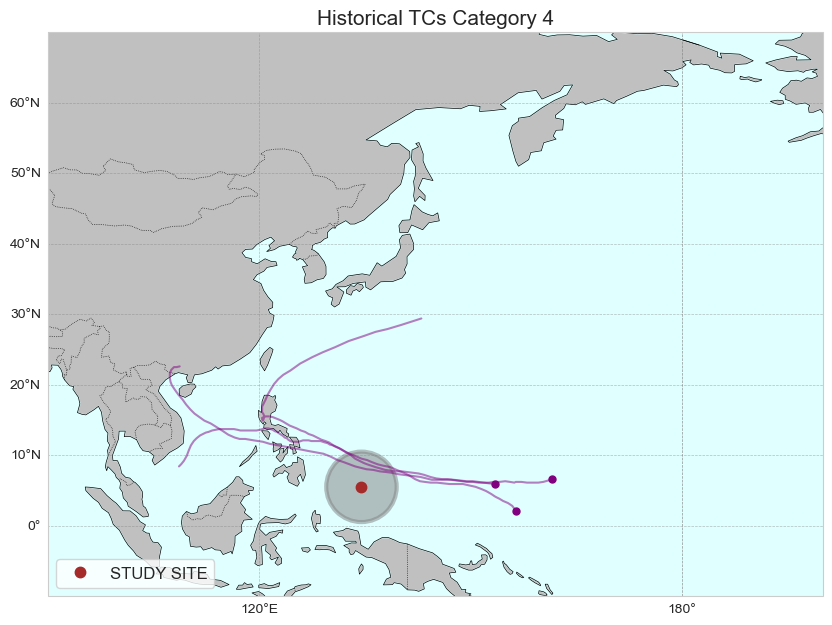

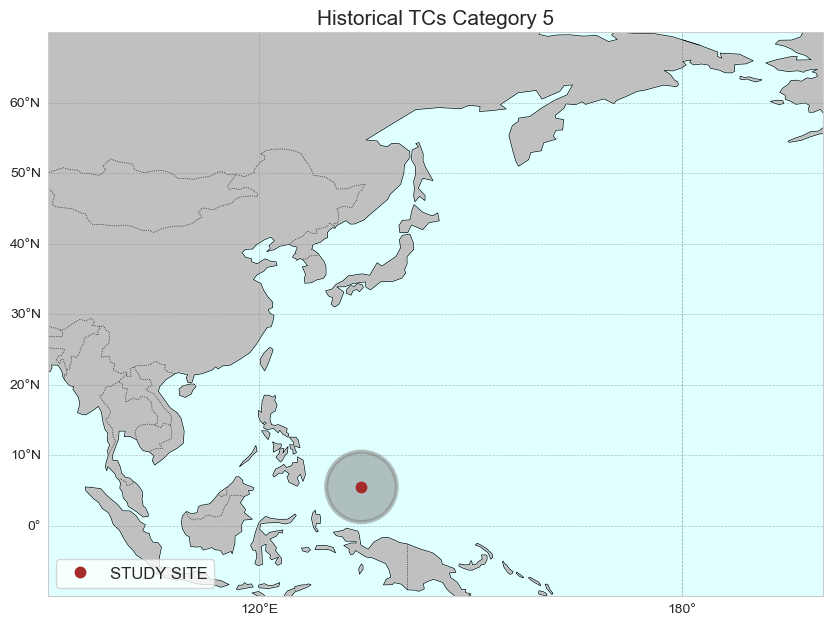

In [ ]:

for category in np.arange(3, 6, 1):

    tcs_cat = tcs_sel.where(tcs_sel_params.category == category, drop = True)
    tcs_cat_params = tcs_sel_params.where(tcs_sel_params.category == category, drop = True)

    # r1
    fig, ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical TCs Category {category}', fontsize=15)

### Generate table
Table sumarizing different metrics of the data analyzed in the plots above <br>
Number of TCs for each category

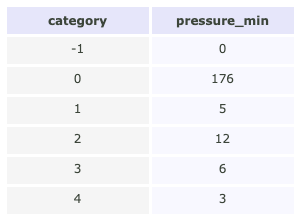

Mean TCs per year:  2.8450704225352115
Mean number of severe TCs per year:  1.12


In [14]:
df_tcs = tcs_sel_params.to_dataframe()
df_tcs['year'] = df_tcs.dmin_date.dt.year
df_t = df_tcs.groupby('category').count()[['pressure_min']]
fig = plot_df_table(df_t, figsize = (300, 220))

mean_tcs_per_year = df_tcs.groupby(df_tcs['dmin_date'].dt.year)['pressure_min'].count()

df_sev = df_tcs.loc[df_tcs['category'] >=3]
mean_tcs_per_year_sev = df_sev.groupby(df_sev['dmin_date'].dt.year)['pressure_min'].count()

print('Mean TCs per year: ', np.nanmean(mean_tcs_per_year))
print('Mean number of severe TCs per year: ', np.round(np.nanmean(mean_tcs_per_year_sev), 2))


## ONI index

The Oceanic Niño Index (ONI) is the standard measure used to monitor El Niño and La Niña events. It is based on sea surface temperature anomalies in the central equatorial Pacific (Niño 3.4 region) averaged over 3-month periods. 

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [15]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'

In [16]:
if update_data:
    df1 = download_oni_index(p_data)
    df1.to_pickle(op.join(path_data, 'oni_index.pkl'))
else:
    df1 = pd.read_pickle(op.join(path_data, 'oni_index.pkl'))

oni = df1

In [17]:
lims = [-.5, .5]
df1 = add_oni_cat(df1, lims = lims)

In [18]:
import pandas as pd
tcs_g = pd.DataFrame(tcs_sel.isel(date_time = 0).time.values)
tcs_g.index = tcs_g[0]
tcs_g.index = pd.DatetimeIndex(tcs_g.index).to_period('M').to_timestamp() + pd.offsets.MonthBegin(0)
tcs_g['oni_cat'] = oni.oni_cat

In [19]:
tcs_sel_params['oni_cat'] = (('storm'), tcs_g['oni_cat'].values)
tcs_sel['oni_cat'] = (('storm'), tcs_g['oni_cat'].values)

In [20]:
# oni['ONI_cat'] = np.where(oni.ONI < lims[0], -1, np.where(oni.ONI > lims[1], 1, 0))
tcs_sel_params['oni_cat'] = (('storm'), tcs_sel.oni_cat.values)

In [21]:
oni_perc_cat = oni.groupby('oni_cat').size() / oni.shape[0] * 100
oni_perc_cat

oni_cat
-1    33.783784
 0    36.486486
 1    29.729730
dtype: float64

In [22]:
tcs_perc_cat = tcs_sel_params.to_dataframe().groupby('oni_cat').size() * 100 / tcs_sel_params.to_dataframe().shape[0]
tcs_perc_cat

oni_cat
-1.0    30.746269
 0.0    43.283582
 1.0    25.373134
dtype: float64

In [23]:
#Relavice probability
tcs_perc_cat / oni_perc_cat

oni_cat
-1.0    0.910090
 0.0    1.186291
 1.0    0.853460
dtype: float64

In [24]:
time = tcs_sel_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)
tc_c = pd.DataFrame(cu, index = u)
time_sev = tcs_sel_params.where(tcs_sel_params.category >= 3, drop = True).dmin_date.dt.year.values
u_sev, cu_sev = np.unique(time_sev, return_counts=True)
tc_c_sev = pd.DataFrame(cu_sev, index = u_sev)

In [25]:
oni_y = oni.groupby(oni.index.year).min()
oni_y['tc_counts'] = tc_c
oni_y['tc_counts_sev'] = tc_c_sev

In [26]:
oni_y['oni_cat'] = oni_y.oni_cat.values

The following bar plot represents the severe TC counts over time. The color of the bar represents wether it is a El Niño or La Niña year.

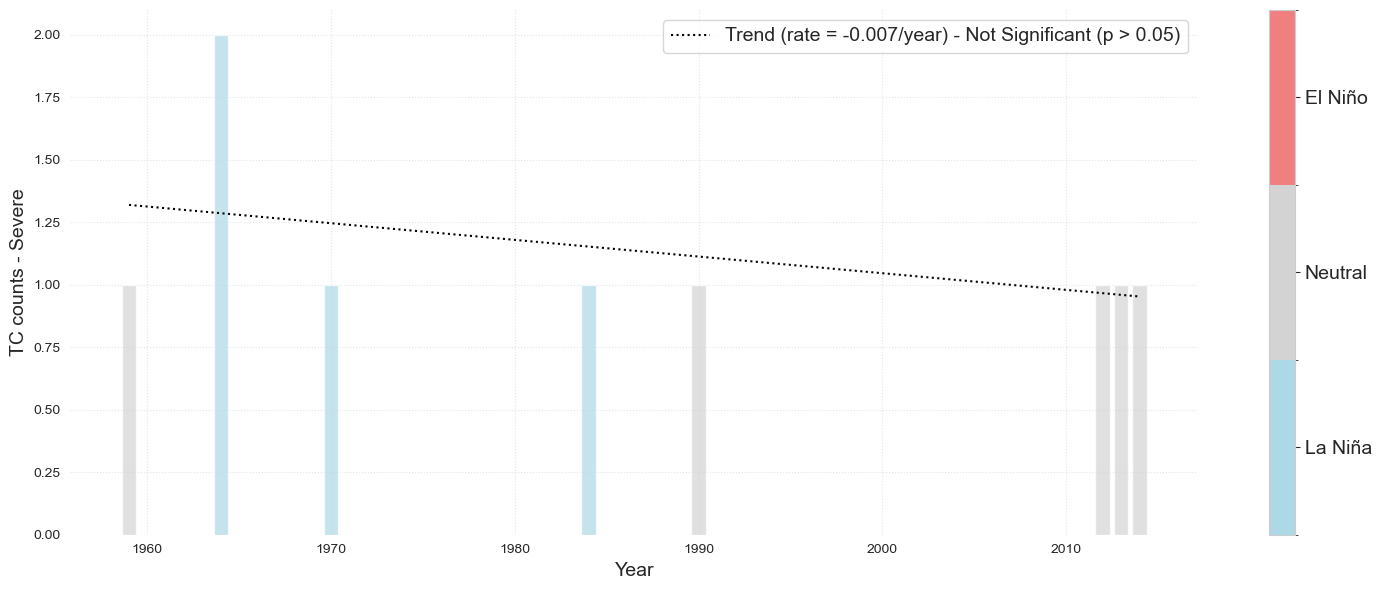

In [27]:
ax = plot_bar_probs_ONI(oni_y, 'tc_counts_sev', y_label= 'TC counts - Severe');
plt.savefig(op.join(path_figs, f'F9_TCs_severe_bars_trend.png'), dpi=300, bbox_inches='tight')



## SEVERE TCs

Category 3, 4 and 5

The following plots represent all the **severe** TCs in the record for the three different phases of the El Niño Southern Oscillation: "El Niño", "Neutral" and "La Niña"

In [28]:
storms_severe_ids = tcs_sel_params.storm.where(tcs_sel_params.category >= 3, drop = True).values

In [29]:
storms_severe = tcs_sel.sel(storm = storms_severe_ids)
storm_severe_params = tcs_sel_params.sel(storm = storms_severe_ids)

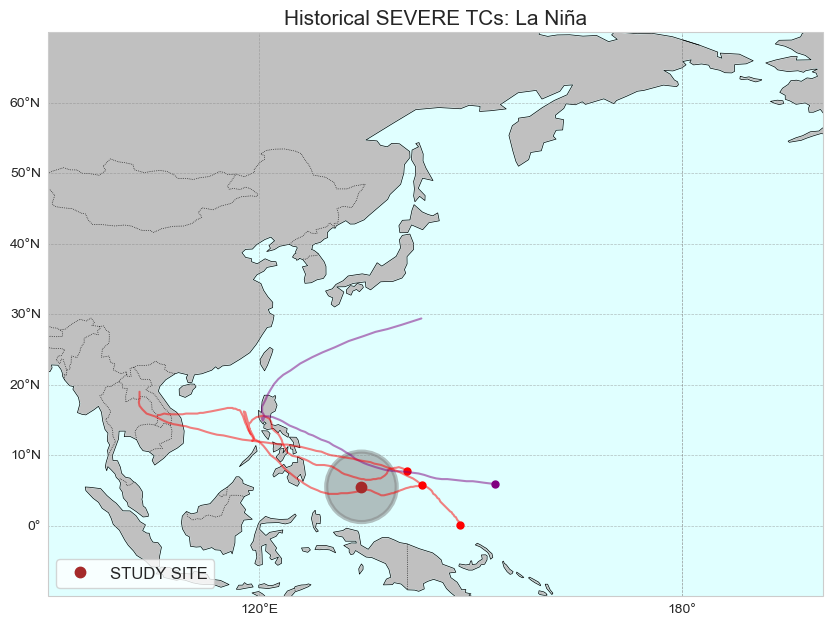

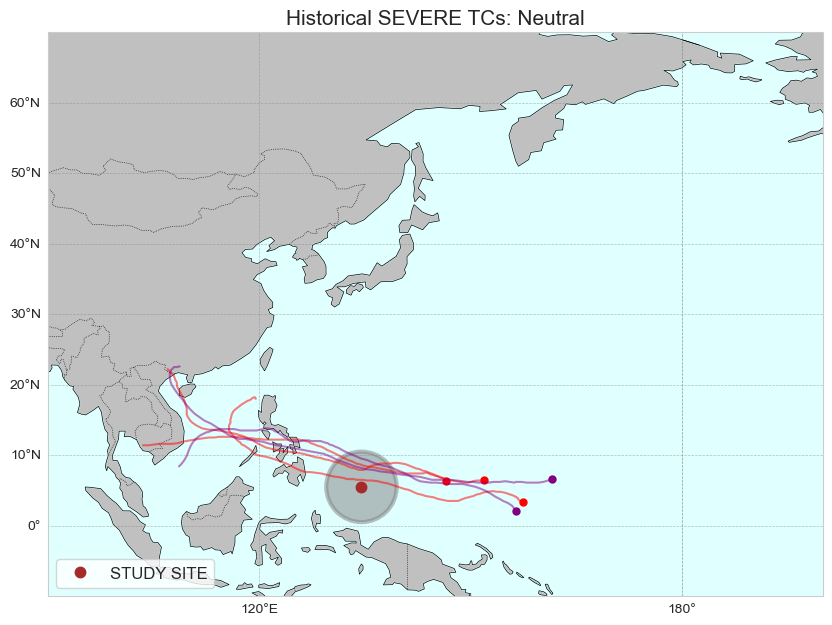

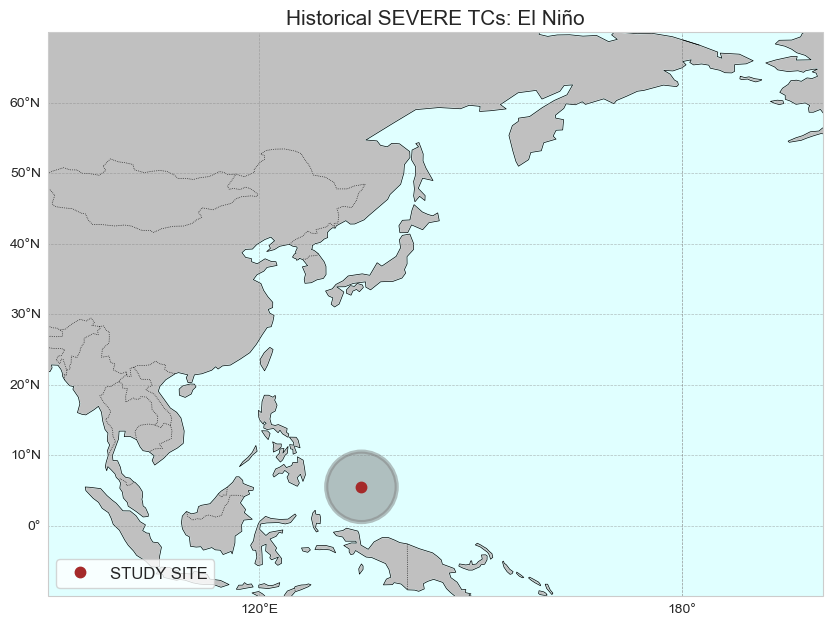

In [ ]:
names_cat = ['La Niña', 'Neutral', 'El Niño']
for ic, category in enumerate([-1, 0, 1]):

    tcs_cat = storms_severe.where(storm_severe_params.oni_cat == category, drop = True)
    tcs_cat_params = storm_severe_params.where(storm_severe_params.oni_cat == category, drop = True)

    fig, ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical SEVERE TCs: {names_cat[ic]}', fontsize=15)
    plt.savefig(op.join(path_figs, f'F9_TCs_{names_cat[ic]}_SEVERE.png'), dpi=300, bbox_inches='tight')
    